#### Top

# Chapter 5 Data Filtering and Selection

* [5.0 Imports and Setup](#5.0-Imports-and-Setup)
* [5.1 Introduction](#5.1-Introduction)
* [5.2 Getting the Data](#5.2-Getting-the-Data)
* [5.3 Filtering with Expressions](#5.3-Filtering-with-Expressions)
* [5.4 Filtering with Keywords](#5.4-Filtering-with-Keywords)
* [5.5 Filtering with Dates](#5.5-Filtering-with-Dates)
* [5.6 Advanced Filtering Techniques](#5.6-Advanced-Filtering-Techniques)
* [5.7 More Filtering with Window Expressions](#5.7-More-Filtering-with-Window-Expressions)
* [5.8 Manipulating Data with Conditional Expressions](#5.8-Manipulating-Data-with-Conditional-Expressions)
* [5.9 Handling Missing Data](#5.9-Handling-Missing-Data)
* [5.10 Dropping Rows with Missing Values](#5.10-Dropping-Rows-with-Missing-Values)
* [5.11 Filling in Missing Values](#5.11-Filling-in-Missing-Values)
* [5.12 Filling in Time Series Missing Values](#5.12-Filling-in-Time-Series-Missing-Values)
* [5.13 Chapter Methods and Functions](#5.13-Chapter-Methods-and-Functions)



---
# 5.0 Imports and Setup

[back to Top](#Top)

In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import chardet
import pprint as pp
import hvplot.polars
hvplot.extension('matplotlib')

# pl.enable_string_cache()

matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
pd.options.mode.copy_on_write = True
print(pd.options.mode.copy_on_write)
pl.Config.set_verbose(True)
pl.show_versions()

def HR():
    print("-"*40)

@pl.Config(tbl_cols=-1, ascii_tables=True)
def tight_layout(df: pl.DataFrame, n=5) -> None:
    with pl.Config(tbl_cols=-1, fmt_str_lengths=n):
        print(df)

def detect_encoding(filename: str) -> str:
    """Return the most probable character encoding for a file."""
    with open(filename, "rb") as f:
        raw_data = f.read()
        print(raw_data)
        result = chardet.detect(raw_data)
        return result["encoding"]

True
--------Version info---------
Polars:              1.9.0
Index type:          UInt32
Platform:            macOS-12.7.6-x86_64-i386-64bit
Python:              3.11.5 (main, Jan 16 2024, 17:25:53) [Clang 14.0.0 (clang-1400.0.29.202)]

----Optional dependencies----
adbc_driver_manager  1.1.0
altair               5.4.0
cloudpickle          3.0.0
connectorx           0.3.3
deltalake            0.19.1
fastexcel            0.11.6
fsspec               2023.12.2
gevent               24.2.1
great_tables         0.10.0
matplotlib           3.9.2
nest_asyncio         1.6.0
numpy                2.0.2
openpyxl             3.1.5
pandas               2.2.2
pyarrow              17.0.0
pydantic             2.8.2
pyiceberg            0.6.1
sqlalchemy           2.0.32
torch                <not installed>
xlsx2csv             0.8.3
xlsxwriter           3.2.0


---
# 5.1 Introduction

[back to Top](#Top)

It is very common in data analysis to **filter and select specific rows and columns** from a dataset. This chapter covers:

* Basics of data filtering and selection
* Conditional statements
* Boolean indexing
* Query expressions
* Using masks and filters
* Working with null values
* Applying dynamic queries based on external criteria


---
**Notes on StringCache**

Context manager for enabling and disabling the global string cache.

Categorical columns created under the same global string cache have the same underlying physical value when string values are equal. This allows the columns to be concatenated or used in a join operation, for example.

Enabling the global string cache introduces some overhead. The amount of overhead depends on the number of categories in your data. It is advised to enable the global string cache only when strictly necessary.

If StringCache calls are nested, the global string cache will only be disabled and cleared when the outermost context exits.

* https://docs.pola.rs/py-polars/html/reference/api/polars.StringCache.html#polars.StringCache

---
# 5.2 Getting the Data

[back to Top](#Top)

In [2]:
path = 'data/vehicles.csv'
raw = pl.read_csv(path, null_values=['NA'])
print(raw.shape)
print(f"{raw.estimated_size(unit='mb'):.2f}MB")


@pl.StringCache()
def tweak_auto(df):
    cols = ['year', 'make', 'model', 'displ', 'cylinders', 'trany', 
           'drive', 'VClass', 'fuelType', 'barrels08', 'city08', 
           'highway08', 'createdOn']
    return (
        df
        .select(pl.col(cols))
        .with_columns( 
            pl.col('year').cast(pl.Int16),
            pl.col(['cylinders', 'highway08', 'city08']).cast(pl.UInt8),
            pl.col(['displ', 'barrels08']).cast(pl.Float32),
            pl.col(['make', 'model', 'VClass', 'drive', 'fuelType']).cast(pl.Categorical),
            pl.col('createdOn').str.to_datetime('%a %b %d %H:%M:%S %Z %Y'),
            is_automatic=pl.col('trany')                    
               .str.contains('Automatic')
               .fill_null('Automatic'),
            num_gears=pl.col('trany')
                .str.extract(r'(\d+)')
                .cast(pl.UInt8)
                .fill_null(6)
        )
    )

autos = tweak_auto(raw)
print(type(autos))
print(autos.shape)
print(f"{autos.estimated_size(unit='mb'):.2f}MB")

(48202, 84)
29.34MB
<class 'polars.dataframe.frame.DataFrame'>
(48202, 15)
2.94MB


avg line length: 434.78027
std. dev. line length: 23.885818
initial row estimate: 47850
no. of chunks: 4 processed by: 4 threads.


---
# 5.3 Filtering with Expressions
[back to Top](#Top)

* The most basic way to filter data is by creating conditionals using expressions and Boolean operators.
* Then we combine those expressions with `.filter()` to select rows that satisfy the condition.
* In this example, select all cars with a fuel efficiency of 40 MPG or higher.

In [3]:
(
    autos
    .filter(
        pl.col('city08')>40
    )
    .select(
        pl.col(['city08']),
        pl.all().exclude(['city08'])
    )
    .sort(by='city08')
)

dataframe filtered


city08,year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,highway08,createdOn,is_automatic,num_gears
u8,i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,datetime[μs],str,u8
41,2010,"""Ford""","""Fusion Hybrid FWD""",2.5,4,"""Automatic (variable gear ratio…","""Front-Wheel Drive""","""Midsize Cars""","""Regular""",7.628461,36,2013-01-01 00:00:00,"""true""",6
41,2010,"""Mercury""","""Milan Hybrid FWD""",2.5,4,"""Automatic (variable gear ratio…","""Front-Wheel Drive""","""Midsize Cars""","""Regular""",7.628461,36,2013-01-01 00:00:00,"""true""",6
41,2011,"""Mercury""","""Milan Hybrid FWD""",2.5,4,"""Automatic (variable gear ratio…","""Front-Wheel Drive""","""Midsize Cars""","""Regular""",7.829211,35,2013-01-01 00:00:00,"""true""",6
41,2011,"""Lincoln""","""MKZ Hybrid FWD""",2.5,4,"""Automatic (variable gear ratio…","""Front-Wheel Drive""","""Midsize Cars""","""Regular""",7.829211,35,2013-01-01 00:00:00,"""true""",6
41,2011,"""Ford""","""Fusion Hybrid FWD""",2.5,4,"""Automatic (variable gear ratio…","""Front-Wheel Drive""","""Midsize Cars""","""Regular""",7.829211,35,2013-01-01 00:00:00,"""true""",6
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
151,2023,"""Hyundai""","""Ioniq 6 Standard Range RWD""",null,null,"""Automatic (A1)""","""Rear-Wheel Drive""","""Midsize Cars""","""Electricity""",0.06,120,2023-05-17 00:00:00,"""true""",1
151,2024,"""Hyundai""","""Ioniq 6 Standard Range RWD""",null,null,"""Automatic (A1)""","""Rear-Wheel Drive""","""Midsize Cars""","""Electricity""",0.06,120,2023-07-31 00:00:00,"""true""",1
151,2025,"""Hyundai""","""Ioniq 6 Standard Range""",null,null,"""Automatic (A1)""","""Rear-Wheel Drive""","""Midsize Cars""","""Electricity""",0.06,120,2024-08-25 00:00:00,"""true""",1


Another example of filtering with Booleans.

In [4]:
makes = ['Ford', 'Toyota']

(
    autos
    .with_columns(pl.col('make').cast(pl.String))
    .filter(
        pl.col('make').is_in(makes) 
        & (pl.col('city08') > 50)
    )
    .select(['year', 'make', 'city08', 'highway08'])
    .sort(by='city08', descending=True)
)

dataframe filtered


year,make,city08,highway08
i16,str,u8,u8
2023,"""Toyota""",131,107
2024,"""Toyota""",131,107
2023,"""Toyota""",125,103
2024,"""Toyota""",121,102
2017,"""Ford""",118,96
…,…,…,…
2023,"""Toyota""",51,53
2023,"""Toyota""",51,44
2024,"""Toyota""",51,53


* We can combine multiple operations by using the `&` and `|` operators.
* We can negate a condition by using the `~` operator, the *not* operator.
* We can also chain calls to `.filter`.
* In this example, select all Toyotas with a fuel efficiency of 40 MPG or higher.

In [5]:
(
    autos
    .filter(pl.col('city08') > 40)
    .filter(pl.col('make') == 'Toyota')
    .select(['year', 'make', 'model', 'city08'])
)

dataframe filtered
dataframe filtered


year,make,model,city08
i16,cat,cat,u8
2000,"""Toyota""","""RAV4 EV""",81
2001,"""Toyota""","""Prius""",42
2001,"""Toyota""","""RAV4 EV""",81
2002,"""Toyota""","""Prius""",42
2002,"""Toyota""","""RAV4 EV""",87
…,…,…,…
2025,"""Toyota""","""Camry HEV FF LE""",53
2025,"""Toyota""","""Camry HEV FF SE/XLE/XSE""",48
2025,"""Toyota""","""Camry HEV AWD LE""",51


* We can also put multiple conditions in `.filter()`.

In [6]:
(
    autos
    .filter(
        pl.col('city08') > 40,
        pl.col('make') == 'Toyota'
    )
    .select(['year', 'make', 'model', 'city08'])
)

dataframe filtered


year,make,model,city08
i16,cat,cat,u8
2000,"""Toyota""","""RAV4 EV""",81
2001,"""Toyota""","""Prius""",42
2001,"""Toyota""","""RAV4 EV""",81
2002,"""Toyota""","""Prius""",42
2002,"""Toyota""","""RAV4 EV""",87
…,…,…,…
2025,"""Toyota""","""Camry HEV FF LE""",53
2025,"""Toyota""","""Camry HEV FF SE/XLE/XSE""",48
2025,"""Toyota""","""Camry HEV AWD LE""",51


* In the above styles, it is not clear what kinds of filtering is being done.
* Is it doing both conditions, or one or the other?
* To be more explicit, using boolean operations like `&`, `|` and `~` to combine conditions.
* Here is a clearer version of the previous example.

In [7]:
(
    autos
    .filter(
        (pl.col('make') == 'Toyota') & (pl.col('city08') > 40)
    )
    .select(['year', 'make', 'model', 'city08'])
)

dataframe filtered
dataframe filtered


year,make,model,city08
i16,cat,cat,u8
2000,"""Toyota""","""RAV4 EV""",81
2001,"""Toyota""","""Prius""",42
2001,"""Toyota""","""RAV4 EV""",81
2002,"""Toyota""","""Prius""",42
2002,"""Toyota""","""RAV4 EV""",87
…,…,…,…
2025,"""Toyota""","""Camry HEV FF LE""",53
2025,"""Toyota""","""Camry HEV FF SE/XLE/XSE""",48
2025,"""Toyota""","""Camry HEV AWD LE""",51


---
# 5.4 Filtering with Keywords

[back to Top](#Top)

* Polars has shortcuts for equality comparisons, via keywords arguments.
* In this example, we want all the *make* rows that are *Ford*

In [8]:
(
    autos
    .filter(pl.col('make') == 'Ford')
    .select(['year', 'make', 'model', 'city08'])
)

dataframe filtered


year,make,model,city08
i16,cat,cat,u8
1993,"""Ford""","""Taurus""",18
1993,"""Ford""","""Taurus SHO""",16
1993,"""Ford""","""Taurus""",17
1993,"""Ford""","""Thunderbird""",17
1993,"""Ford""","""Thunderbird""",15
…,…,…,…
1993,"""Ford""","""Escort FS""",26
1993,"""Ford""","""Tempo""",19
1993,"""Ford""","""Tempo""",21


* This by itself is very limited in what it can do.
* This only works for equality comparisons.

---
# 5.5 Filtering with Dates

[back to Top](#Top)

* Here we filter on *createdOn*, a date column.
* Compare dates to specific Python `datetime` objects.
* Select all dates from March 2018 forward.

In [9]:
# check this is a datetime type
autos.schema['createdOn']

Datetime(time_unit='us', time_zone=None)

In [10]:
from datetime import datetime

mar2018 = datetime(2018, 3, 1)
print(mar2018)

(
    autos
    .filter(pl.col('createdOn') >= mar2018)
    .select(['year', 'createdOn', 'make', 'model', 'city08'])
    .sort(by='createdOn')
)

2018-03-01 00:00:00


dataframe filtered


year,createdOn,make,model,city08
i16,datetime[μs],cat,cat,u8
2019,2018-03-02 00:00:00,"""Genesis""","""G70 AWD""",17
2019,2018-03-02 00:00:00,"""Genesis""","""G70 RWD""",17
2019,2018-03-02 00:00:00,"""Genesis""","""G70 AWD""",21
2019,2018-03-02 00:00:00,"""Genesis""","""G70 RWD""",22
2019,2018-03-02 00:00:00,"""Genesis""","""G70 RWD""",18
…,…,…,…,…
2025,2024-10-17 00:00:00,"""Land Rover""","""Defender 130 Outbound""",16
2025,2024-10-17 00:00:00,"""Nissan""","""Pathfinder 4WD Platinum""",20
2025,2024-10-17 00:00:00,"""Porsche""","""Cayenne Turbo GT""",15


* We can also use `is_between()` to select dates between two dates.
* This method works for any ordinal types, not just dates.
* For ex, we select all cars with miles per gallon between 40 and 50.

In [11]:
(
    autos
    .filter(pl.col('city08').is_between(40,50))
    .sort('city08')
    .select(['year', 'make', 'model', 'VClass', 'city08'])
)

dataframe filtered


year,make,model,VClass,city08
i16,cat,cat,cat,u8
1985,"""Honda""","""Civic CRX HF""","""Two Seaters""",40
2003,"""Honda""","""Civic Hybrid""","""Compact Cars""",40
2006,"""Honda""","""Civic Hybrid""","""Compact Cars""",40
2007,"""Honda""","""Civic Hybrid""","""Compact Cars""",40
2008,"""Honda""","""Civic Hybrid""","""Compact Cars""",40
…,…,…,…,…
2024,"""Toyota""","""Corolla Hybrid""","""Compact Cars""",50
2024,"""Toyota""","""Prius Prime""","""Midsize Cars""",50
2025,"""Honda""","""Civic 4Dr""","""Midsize Cars""",50


* Next, select all the cars with a *createdOn* date between March 2018 and 5 years prior.


In [12]:
from datetime import timedelta

mar2013 = mar2018 - timedelta(days=5*365)
print(mar2013)

(
    autos
    .filter(pl.col('createdOn').is_between(mar2013, mar2018))
    .select(['year', 'createdOn', 'make', 'model', 'VClass', 'city08', ])
    .sort('createdOn')
)

2013-03-02 00:00:00


dataframe filtered


year,createdOn,make,model,VClass,city08
i16,datetime[μs],cat,cat,cat,u8
2014,2013-10-29 00:00:00,"""Lexus""","""GS 350""","""Midsize Cars""",19
2014,2013-10-29 00:00:00,"""Nissan""","""Frontier 2WD""","""Small Pickup Trucks 2WD""",17
2014,2013-10-29 00:00:00,"""Nissan""","""Frontier 2WD""","""Small Pickup Trucks 2WD""",19
2014,2013-10-29 00:00:00,"""Nissan""","""Frontier 2WD""","""Small Pickup Trucks 2WD""",16
2014,2013-10-29 00:00:00,"""Nissan""","""Frontier 2WD""","""Small Pickup Trucks 2WD""",16
…,…,…,…,…,…
2018,2018-02-26 00:00:00,"""Land Rover""","""Range Rover LWB""","""Standard Sport Utility Vehicle…",16
2018,2018-02-26 00:00:00,"""Land Rover""","""Range Rover SVA""","""Standard Sport Utility Vehicle…",14
2018,2018-02-26 00:00:00,"""Land Rover""","""Range Rover LWB SVA""","""Standard Sport Utility Vehicle…",13


---
# 5.6 Advanced Filtering Techniques

[back to Top](#Top)

* Find the high outliers for the *city08* column.
* Filter out all values with a Z-score > 3.
* The Z-score is the number of standard deviations away from the mean.
* This is a common technique for finding outliers when the data is normally distributed.
* Then select the columns you want to see.

**Notes on standardization and normalization**

The key differences between normalization and standardization in the context of data preprocessing with Polars are:

Normalization:
- Normalization refers to rescaling the data to a common range, typically between 0 and 1.
- It preserves the shape of the original data distribution.
- Polars does not have a built-in normalization function, but you can create your own function to normalize columns.

Standardization:
- Standardization refers to centering the data around a mean of 0 and scaling it to have a standard deviation of 1.
- It changes the shape of the original data distribution.
- In Polars, you can standardize a column using the `mean()` and `std()` functions along with arithmetic operations, as shown in this example:

```python
import polars as pl

def standardize(x):
    return (x - x.mean()) / x.std()

df = pl.DataFrame({"x": [1, 2, 3, 4, 5]})
df = df.with_column(pl.col("x").map(standardize).alias("x_standardized"))
```

This will create a new column `x_standardized` containing the standardized values of `x`.

So in summary, normalization rescales data to a common range like 0 to 1, while standardization centers the data around 0 mean and scales it to unit variance. Polars does not have built-in functions for these operations, but you can create your own functions using existing methods like `mean()`, `std()`, `min()`, `max()`, and arithmetic operations.

In [13]:
pl.col('city08') > 3

<Expr ['[(col("city08")) > (dyn int: 3…'] at 0x12594B550>

In [14]:
# Center the data around a mean of 0, and scale it to have a standard deviation of 1.
def standardize(col):
    return (col - col.mean()) / col.std()

(
    autos
    .with_columns(
        standardize(pl.col('city08')).alias('standardized_city08')
    )
    .filter(
        pl.col('standardized_city08') > 3
    )
    .select(['year', 'make', 'model', 'VClass', 'city08', 'standardized_city08'])
)

dataframe filtered


year,make,model,VClass,city08,standardized_city08
i16,cat,cat,cat,u8,f64
2000,"""Nissan""","""Altra EV""","""Midsize Station Wagons""",81,4.82467
2000,"""Toyota""","""RAV4 EV""","""Sport Utility Vehicle - 2WD""",81,4.82467
2001,"""Toyota""","""RAV4 EV""","""Sport Utility Vehicle - 2WD""",81,4.82467
2001,"""Ford""","""Th!nk""","""Two Seaters""",74,4.271661
2001,"""Nissan""","""Hyper-Mini""","""Two Seaters""",84,5.061674
…,…,…,…,…,…
2024,"""Mercedes-Benz""","""EQB 300 4matic""","""Small Sport Utility Vehicle 4W…",89,5.456681
2024,"""Tesla""","""Model 3 Long Range AWD-E""","""Midsize Cars""",133,8.932738
2024,"""Tesla""","""Model Y Long Range AWD-I""","""Small Sport Utility Vehicle 4W…",123,8.142725


* We can also combine these with **window functions**.
* Here we find outliers for each *make* and *year* combination.
* For this, use a `.over(['year', 'make'])` to our standard deviation calculation.

In [15]:
(
    autos
    .filter(
         standardize(pl.col('city08')).over(['year', 'make']) > 3
    )
    .select(['year', 'make', 'model', 'trany', 'VClass', 'city08'])
    .sort(by=['year', 'make'])
)

dataframe filtered


year,make,model,trany,VClass,city08
i16,cat,cat,str,cat,u8
1984,"""Pontiac""","""1000""","""Manual 5-spd""","""Subcompact Cars""",33
1984,"""Pontiac""","""1000""","""Manual 5-spd""","""Subcompact Cars""",33
1984,"""Suzuki""","""SJ 410 4WD""","""Manual 4-spd""","""Special Purpose Vehicle 4WD""",22
1984,"""Suzuki""","""SJ410K P/U 4WD""","""Manual 4-spd""","""Small Pickup Trucks 4WD""",22
1984,"""Suzuki""","""SJ 410V 4WD""","""Manual 4-spd""","""Special Purpose Vehicle 4WD""",22
…,…,…,…,…,…
2025,"""Chevrolet""","""Blazer EV AWD""","""Automatic (A1)""","""Small Sport Utility Vehicle 4W…",102
2025,"""Kia""","""Niro Electric""","""Automatic (A1)""","""Small Sport Utility Vehicle 2W…",126
2025,"""Aston Martin""","""DB12 V8""","""Automatic 8-spd""","""Minicompact Cars""",15


In [16]:
# Variation using group_by at the end for a more condensed view
(
    autos
    .filter(
        standardize(pl.col('city08')).over(['year', 'make']) > 3
    )
    .select(['year', 'make', 'model', 'trany', 'VClass', 'city08'])
    .group_by('year', 'make')
    .all()
    .sort(by=['year', 'make'])
)

dataframe filtered
keys/aggregates are not partitionable: running default HASH AGGREGATION


year,make,model,trany,VClass,city08
i16,cat,list[cat],list[str],list[cat],list[u8]
1984,"""Pontiac""","[""1000"", ""1000""]","[""Manual 5-spd"", ""Manual 5-spd""]","[""Subcompact Cars"", ""Subcompact Cars""]","[33, 33]"
1984,"""Suzuki""","[""SJ410K P/U 4WD"", ""SJ 410 4WD"", ""SJ 410V 4WD""]","[""Manual 4-spd"", ""Manual 4-spd"", ""Manual 4-spd""]","[""Small Pickup Trucks 4WD"", ""Special Purpose Vehicle 4WD"", ""Special Purpose Vehicle 4WD""]","[22, 22, 22]"
1984,"""Chevrolet""","[""Chevette"", ""Chevette"", ""Chevette""]","[""Automatic 3-spd"", ""Manual 5-spd"", ""Manual 5-spd""]","[""Subcompact Cars"", ""Subcompact Cars"", ""Subcompact Cars""]","[28, 33, 33]"
1984,"""Ford""","[""Escort"", ""Escort"", … ""Escort Wagon""]","[""Manual 5-spd"", ""Manual 5-spd"", … ""Manual 5-spd""]","[""Compact Cars"", ""Compact Cars"", … ""Small Station Wagons""]","[35, 31, … 31]"
1984,"""Mercury""","[""Lynx""]","[""Manual 5-spd""]","[""Compact Cars""]",[35]
…,…,…,…,…,…
2025,"""Nissan""","[""LEAF"", ""LEAF SV""]","[""Automatic (A1)"", ""Automatic (A1)""]","[""Midsize Cars"", ""Midsize Cars""]","[123, 121]"
2025,"""Bentley""","[""Bentayga"", ""Bentayga EWB""]","[""Automatic (S8)"", ""Automatic (S8)""]","[""Standard Sport Utility Vehicle 4WD"", ""Standard Sport Utility Vehicle 4WD""]","[14, 14]"
2025,"""Chevrolet""","[""Blazer EV AWD""]","[""Automatic (A1)""]","[""Small Sport Utility Vehicle 4WD""]",[102]


---
# 5.7 More Filtering with Window Expressions

[back to Top](#Top)

* This is a more complicated example.
* Find cars in production for over 10 years.
* First calculate the *model_age*.
* We cannot group by *model* since that will aggregate all the rows for each model.
* Instead, use a *model_age* value for each row.
* For this, use a *window expression*.
* Window expressions apply an aggregation to a group of rows.
* We can use `.over()` to apply our expression to a group of rows.
* Here, use `.over('model')` to apply the expression to each model.
* Use `.with_columns()` to append to the existing dataframe.

In [17]:
# Using .with_columns guarantees sequential execution 
# and access to previously declared variables like 'model_age'
(
    autos
    .with_columns(
        model_age=(
            pl.col('year').max() - pl.col('year').min()
        )
        .over('model')
    )
    .select(['year','make', 'model','displ','cylinders','trany', 'model_age'])
    .sort(by=['model_age'], descending=True)
)

year,make,model,displ,cylinders,trany,model_age
i16,cat,cat,f32,u8,str,i16
1993,"""Toyota""","""Corolla""",1.6,4,"""Automatic 3-spd""",41
1993,"""Toyota""","""Corolla""",1.6,4,"""Manual 5-spd""",41
1993,"""Toyota""","""Corolla""",1.8,4,"""Automatic 4-spd""",41
1993,"""Toyota""","""Corolla""",1.8,4,"""Manual 5-spd""",41
1994,"""Chevrolet""","""Corvette""",5.7,8,"""Manual 6-spd""",41
…,…,…,…,…,…,…
1992,"""Dodge""","""Caravan C/V/Grand Caravan 4WD""",3.3,6,"""Automatic 4-spd""",0
1992,"""PAS Inc - GMC""","""Pas-typhoon""",4.3,6,"""Automatic 4-spd""",0
1993,"""Ferrari""","""Ferrari 348 TB/TS""",3.4,8,"""Manual 5-spd""",0


* Next, filter out rows where *model_age* is less than 10.
* For this, add `.filter(col('model_age')>10)` to end of the previous expression.

In [18]:
(
    autos
    .with_columns(
        model_age=(
            pl.col('year').max() - pl.col('year').min()
        )
        .over('model')
    )
    .filter(pl.col('model_age')>10)
    .select(['year','make', 'model','displ','cylinders','trany', 'model_age'])
    .sort(by=['model_age'], descending=True)
)

dataframe filtered


year,make,model,displ,cylinders,trany,model_age
i16,cat,cat,f32,u8,str,i16
1993,"""Toyota""","""Corolla""",1.6,4,"""Automatic 3-spd""",41
1993,"""Toyota""","""Corolla""",1.6,4,"""Manual 5-spd""",41
1993,"""Toyota""","""Corolla""",1.8,4,"""Automatic 4-spd""",41
1993,"""Toyota""","""Corolla""",1.8,4,"""Manual 5-spd""",41
1994,"""Chevrolet""","""Corvette""",5.7,8,"""Manual 6-spd""",41
…,…,…,…,…,…,…
1993,"""Mercury""","""Tracer""",1.9,4,"""Manual 5-spd""",11
1993,"""Saturn""","""SL""",1.9,4,"""Automatic 4-spd""",11
1993,"""Saturn""","""SL""",1.9,4,"""Automatic 4-spd""",11


In [19]:
# Attempt at further summary
(
    autos
    .with_columns(
        model_age=(
            pl.col('year').max() - pl.col('year').min()
        )
        .over('model')
    )
    .filter(pl.col('model_age')>10)
    .select(['year','make', 'model','displ','cylinders','trany', 'model_age'])
    .group_by(['make', 'model'])
    .all()
    .sort(by=pl.col('model_age').list.max(), descending=True)
)

dataframe filtered
keys/aggregates are not partitionable: running default HASH AGGREGATION


make,model,year,displ,cylinders,trany,model_age
cat,cat,list[i16],list[f32],list[u8],list[str],list[i16]
"""Nissan""","""Sentra""","[1994, 1994, … 1993]","[1.6, 1.6, … 2.0]","[4, 4, … 4]","[""Automatic 4-spd"", ""Manual 5-spd"", … ""Manual 5-spd""]","[41, 41, … 41]"
"""Chevrolet""","""Corvette""","[1994, 1994, … 1993]","[5.7, 5.7, … 5.7]","[8, 8, … 8]","[""Manual 6-spd"", ""Automatic 4-spd"", … ""Manual 6-spd""]","[41, 41, … 41]"
"""Honda""","""Accord""","[1994, 1994, … 1993]","[2.2, 2.2, … 2.2]","[4, 4, … 4]","[""Automatic 4-spd"", ""Automatic 4-spd"", … ""Manual 5-spd""]","[41, 41, … 41]"
"""Volkswagen""","""Jetta""","[1996, 1996, … 1992]","[1.9, 2.0, … 1.8]","[4, 4, … 4]","[""Manual 5-spd"", ""Automatic 4-spd"", … ""Manual 5-spd""]","[41, 41, … 41]"
"""Toyota""","""Corolla""","[1993, 1993, … 1992]","[1.6, 1.6, … 1.6]","[4, 4, … 4]","[""Automatic 3-spd"", ""Manual 5-spd"", … ""Manual 5-spd""]","[41, 41, … 41]"
…,…,…,…,…,…,…
"""Infiniti""","""QX60 FWD""","[2014, 2015, … 2025]","[3.5, 3.5, … 2.0]","[6, 6, … 4]","[""Automatic (AV-S7)"", ""Automatic (AV-S7)"", … ""Automatic (S9)""]","[11, 11, … 11]"
"""Hyundai""","""Azera""","[2006, 2007, … 2017]","[3.8, 3.8, … 3.3]","[6, 6, … 6]","[""Automatic 5-spd"", ""Automatic 5-spd"", … ""Automatic (S6)""]","[11, 11, … 11]"
"""Ford""","""Taurus FWD""","[2008, 2009, … 2019]","[3.5, 3.5, … 3.5]","[6, 6, … 6]","[""Automatic 6-spd"", ""Automatic 6-spd"", … ""Automatic (S6)""]","[11, 11, … 11]"


---
# 5.8 Manipulating Data with Conditional Expressions

[back to Top](#Top)

* A very common operation is the equivalent of an if-else statement to update a column based on a condition.
* Here, assume we want to simplify the fuel type to natural gas, gas, diesel, and electric.
* First, example the values for fuelType in a pseudo .value_counts
* In Polars, we express this via `pl.group_by(col).len()`

In [20]:
(
    autos
    .group_by('fuelType')
    .len()
    .sort(by='len', descending=True)
)

known unique values: 15
run PARTITIONED HASH AGGREGATION


fuelType,len
cat,u32
"""Regular""",29131
"""Premium""",14699
"""Gasoline or E85""",1402
"""Diesel""",1284
"""Electricity""",930
…,…
"""Premium Gas or Electricity""",55
"""Hydrogen""",32
"""Gasoline or natural gas""",20


* There is a native `.value_counts()` expression in Polars.
* This returns a struct.
* **Because it is an expression and not a context, it is not dependent on having a dataframe around.**
* **It also enable the query engine to perform optimizations.**

In [21]:
(
    autos
    .select(
        pl.col('fuelType')
        .value_counts(sort=True)
    )
)

fuelType
struct[2]
"{""Regular"",29131}"
"{""Premium"",14699}"
"{""Gasoline or E85"",1402}"
"{""Diesel"",1284}"
"{""Electricity"",930}"
…
"{""Premium Gas or Electricity"",55}"
"{""Hydrogen"",32}"
"{""Gasoline or natural gas"",20}"


* If we wanted the output individual columns, use `.unnest()`.
* https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.unnest.html#polars.DataFrame.unnest
* Decompose struct columns into separate columns for each of their fields.
* The new columns will be inserted into the dataframe at the location of the struct column.

In [22]:
(
    autos
    .select(
        pl.col('fuelType')
        .value_counts(sort=True)
    )
    .unnest('fuelType')
)

fuelType,count
cat,u32
"""Regular""",29131
"""Premium""",14699
"""Gasoline or E85""",1402
"""Diesel""",1284
"""Electricity""",930
…,…
"""Premium Gas or Electricity""",55
"""Hydrogen""",32
"""Gasoline or natural gas""",20


* We can also pull off just one column by combining the `.struct` attribute with an index operation.

In [23]:
(
    autos
    .select(
        pl.col('fuelType')
        .value_counts(sort=True)
        .struct[0]
    )
)

fuelType
cat
"""Regular"""
"""Premium"""
"""Gasoline or E85"""
"""Diesel"""
"""Electricity"""
…
"""Premium Gas or Electricity"""
"""Hydrogen"""
"""Gasoline or natural gas"""


---
**Back to Manipulating Data with Conditional Expressions**

* Make a new column called *fuelTypeSimple* and set it to the value of *FuelType*.
* We will build up an expression with the Polars `.when()`, `.then()`, `otherwise()`.
* The pseudocode in Polars will look like:

```
(
    pl
    .when(COND_EXPR1)
    .then(EXPR1)
    .when(COND_EXPR2)
    .then(EXPR2)
    ... # more when's
    .otherwise(EXPRN) # optional
)
```

In [24]:
fuel_str = pl.col('fuelType').cast(pl.String) # cast to enable str attribute and methods.

simple = (
    pl
    .when(fuel_str.str.contains('Diesel')).then(pl.lit('Diesel'))
    .when(fuel_str.str.contains('CNG')).then(pl.lit('CNG'))
    .when(fuel_str.str.contains('Electricity')).then(pl.lit('Electric'))
    .otherwise(pl.lit('Gasoline'))
)

simple

<Expr ['.when(col("fuelType").strict_c…'] at 0x125965BD0>

In [25]:
(
    autos
    .with_columns(fuelTypeSimple = simple)
    .select(['year', 'make', 'model', 'fuelTypeSimple'])
)

year,make,model,fuelTypeSimple
i16,cat,cat,str
1985,"""Alfa Romeo""","""Spider Veloce 2000""","""Gasoline"""
1985,"""Ferrari""","""Testarossa""","""Gasoline"""
1985,"""Dodge""","""Charger""","""Gasoline"""
1985,"""Dodge""","""B150/B250 Wagon 2WD""","""Gasoline"""
1993,"""Subaru""","""Legacy AWD Turbo""","""Gasoline"""
…,…,…,…
1993,"""Subaru""","""Legacy""","""Gasoline"""
1993,"""Subaru""","""Legacy""","""Gasoline"""
1993,"""Subaru""","""Legacy AWD""","""Gasoline"""


In [26]:
# variation using group by for summary
(
    autos
    .with_columns(fuelTypeSimple = simple)
    .select(['year', 'make', 'model', 'fuelTypeSimple'])
    .group_by('fuelTypeSimple')
    .len()
)

estimated unique values: 3
run PARTITIONED HASH AGGREGATION


fuelTypeSimple,len
str,u32
"""CNG""",60
"""Electric""",1272
"""Gasoline""",45586
"""Diesel""",1284


* We have validated our expression works.
* Next, filter for the *CNG* rows

In [27]:
fuel_str = pl.col('fuelType').cast(pl.String)

simple = (
    pl
    .when(fuel_str.str.contains('Diesel')).then(pl.lit('Diesel'))
    .when(fuel_str.str.contains('CNG')).then(pl.lit('CNG'))
    .when(fuel_str.str.contains('Electricity')).then(pl.lit('Electric'))
    .otherwise(pl.lit('Gasoline'))
)

(
    autos
    # Use .with_columns to enable access to fuelTypeSimple variable in immediately following code
    .with_columns(fuelTypeSimple=simple)
    .filter(pl.col('fuelTypeSimple')=='CNG')
    .select(['year', 'make', 'model', 'fuelTypeSimple'])
)

dataframe filtered


year,make,model,fuelTypeSimple
i16,cat,cat,str
1996,"""Ford""","""Crown Victoria CNG""","""CNG"""
1997,"""Ford""","""Crown Victoria CNG""","""CNG"""
1998,"""Honda""","""Civic CNG""","""CNG"""
1998,"""Ford""","""F250 Pickup 2WD CNG""","""CNG"""
1998,"""Ford""","""E250 Econoline 2WD CNG""","""CNG"""
…,…,…,…
2012,"""Honda""","""Civic Natural Gas""","""CNG"""
2013,"""Honda""","""Civic Natural Gas""","""CNG"""
2014,"""Honda""","""Civic Natural Gas""","""CNG"""


* We don't even need to create a new columns first.
* We can inline the conditional expressions in `.filter()`
* However, it is much clearer to create the column to see the data and inspect it is correct, etc
* Without the *fuelTypeSimple* column, it is very hard to see what this data is about!

In [28]:
(
    autos
    .filter(simple=='CNG')
)

dataframe filtered


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
1996,"""Ford""","""Crown Victoria CNG""",4.6,8,"""Automatic 4-spd""","""Rear-Wheel Drive""","""Large Cars""","""CNG""",0.081083,15,24,2013-01-01 00:00:00,"""true""",4
1997,"""Ford""","""Crown Victoria CNG""",4.6,8,"""Automatic 4-spd""","""Rear-Wheel Drive""","""Large Cars""","""CNG""",0.081083,15,23,2013-01-01 00:00:00,"""true""",4
1998,"""Honda""","""Civic CNG""",1.6,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""CNG""",0.054056,24,31,2013-01-01 00:00:00,"""true""",4
1998,"""Ford""","""F250 Pickup 2WD CNG""",5.4,8,"""Automatic 4-spd""","""Rear-Wheel Drive""","""Standard Pickup Trucks 2WD""","""CNG""",0.132682,10,14,2013-01-01 00:00:00,"""true""",4
1998,"""Ford""","""E250 Econoline 2WD CNG""",5.4,8,"""Automatic 4-spd""","""Rear-Wheel Drive""","""Vans, Cargo Type""","""CNG""",0.132682,10,13,2013-01-01 00:00:00,"""true""",4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2012,"""Honda""","""Civic Natural Gas""",1.8,4,"""Automatic 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""CNG""",0.047081,27,38,2013-01-01 00:00:00,"""true""",5
2013,"""Honda""","""Civic Natural Gas""",1.8,4,"""Automatic 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""CNG""",0.047081,27,38,2013-01-01 00:00:00,"""true""",5
2014,"""Honda""","""Civic Natural Gas""",1.8,4,"""Automatic 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""CNG""",0.047081,27,38,2014-02-17 00:00:00,"""true""",5


* We have been using scalars (*pl.lit*) expressions for the value of `.then` and `.otherwise`.
* We can also use expressions to use the existing column, or a derivation from the column.
* For ex, we want to generalize categorial values to keep only the top-N values, otherwise use *Other*.

---

In this new example:

* Make a new column, *simple_make*, with only the top-10 makes and *Other*.
* First, create an expression to return the top-10 makes.

In [29]:
# Test of top-10
autos.group_by('make').len().sort(by='len', descending=True).head(10).select('make')

known unique values: 145
run PARTITIONED HASH AGGREGATION


make
cat
"""Chevrolet"""
"""Ford"""
"""GMC"""
"""Dodge"""
"""BMW"""
"""Toyota"""
"""Mercedes-Benz"""
"""Nissan"""
"""Porsche"""


In [30]:
top_n = (
    pl.col('make')
    .value_counts(sort=True)
    .struct[0]
    .head(10)
)

# TEST
autos.select(top_n)

make
cat
"""Chevrolet"""
"""Ford"""
"""GMC"""
"""Dodge"""
"""BMW"""
"""Toyota"""
"""Mercedes-Benz"""
"""Nissan"""
"""Porsche"""


In [31]:

top_n = (
    pl.col('make')
    .value_counts(sort=True)
    .struct[0]
    .head(10)
)

top_expr = (
    pl
    .when(pl.col('make').is_in(top_n))
    .then(pl.col('make'))
    .otherwise(pl.lit('Otherwise'))
)

try:
    print(
        autos
        .with_columns(simple_make=top_expr)
        .select(['year', 'simple_make', 'make', 'model'])
        .sort(by=['year', 'simple_make'])
    )
except Exception as e:
    print(e)

cannot compare categoricals coming from different sources, consider setting a global StringCache.

Help: if you're using Python, this may look something like:

    with pl.StringCache():
        # Initialize Categoricals.
        df1 = pl.DataFrame({'a': ['1', '2']}, schema={'a': pl.Categorical})
        df2 = pl.DataFrame({'a': ['1', '3']}, schema={'a': pl.Categorical})
    # Your operations go here.
    pl.concat([df1, df2])

Alternatively, if the performance cost is acceptable, you could just set:

    import polars as pl
    pl.enable_string_cache()

on startup.


* If we want to reuse this functionality, we can create a helper function
* This limits categories


In [32]:
def limit(col_name, n=10, default='other'):
    col = pl.col(col_name)
    top_n = (
        col
        .value_counts(sort=True)
        .struct[0]
        .head(n)
    )
    return (
        pl.when(col.is_in(top_n))
        .then(col)
        .otherwise(pl.lit(default))
    )

In [33]:
try:
    (
        autos
        .with_columns(simple_make=limit('make'))
        .select(['year', 'simple_make', 'make', 'model'])
        .sort(by=['year', 'simple_make'])
    )
except Exception as e:
    print(e)

cannot compare categoricals coming from different sources, consider setting a global StringCache.

Help: if you're using Python, this may look something like:

    with pl.StringCache():
        # Initialize Categoricals.
        df1 = pl.DataFrame({'a': ['1', '2']}, schema={'a': pl.Categorical})
        df2 = pl.DataFrame({'a': ['1', '3']}, schema={'a': pl.Categorical})
    # Your operations go here.
    pl.concat([df1, df2])

Alternatively, if the performance cost is acceptable, you could just set:

    import polars as pl
    pl.enable_string_cache()

on startup.


---
**Note: `CategoricalRemappingWarning`**

The above code has a `CategoricalRemappingWarning`. This is because Polars uses a dictionary to encode categorical values. The value for the *other* parameter was not in the shared dictionary. To overcome this:

* Use `pl.enable_string_cache` to enable string caching. This is best placed at the top of code, immediately after import statements.
* Use the `pl.StringCache` context manager when you create the dataframe, and operations using that dataframe.
* Use `@pl.StringCache()` function decorator as an alternative context manager.



In [34]:
try:
    print("Different context:")
    HR()
    with pl.StringCache():
        autos2 = tweak_auto(raw)
        
    print(
        autos2
        .select(simple_make=limit('make', 20, 'other'))
    )
except Exception as e:
    print(e)

Different context:
----------------------------------------
cannot compare categoricals coming from different sources, consider setting a global StringCache.

Help: if you're using Python, this may look something like:

    with pl.StringCache():
        # Initialize Categoricals.
        df1 = pl.DataFrame({'a': ['1', '2']}, schema={'a': pl.Categorical})
        df2 = pl.DataFrame({'a': ['1', '3']}, schema={'a': pl.Categorical})
    # Your operations go here.
    pl.concat([df1, df2])

Alternatively, if the performance cost is acceptable, you could just set:

    import polars as pl
    pl.enable_string_cache()

on startup.


In [35]:
with pl.StringCache():
    autos2 = tweak_auto(raw)
    
    print(
        autos2
        .select(simple_make=limit('make', 20, 'other'))
    )

shape: (48_202, 1)
+-------------+
| simple_make |
| ---         |
| cat         |
+=============+
| other       |
| other       |
| Dodge       |
| Dodge       |
| Subaru      |
| …           |
| Subaru      |
| Subaru      |
| Subaru      |
| Subaru      |
| Subaru      |
+-------------+


In [36]:
@pl.StringCache()
# This decorator places the tweak_auto function in the same context as wrapper_for_context()
def wrapper_for_context():    
    return(
        tweak_auto(raw)
        .select(simple_make=limit('make', 20, 'other'))
    )
     
test = wrapper_for_context()
test

simple_make
cat
"""other"""
"""other"""
"""Dodge"""
"""Dodge"""
"""Subaru"""
…
"""Subaru"""
"""Subaru"""
"""Subaru"""


---
**Note: More on `CategoricalRemappingWarning`**

* Looking up strings in a global cache has a slight overhead.
* Using the `Enum` type is another option.
* If you know the categories beforehand, you can use the `Enum` type to create a categorical column.
* This is faster than using the string cache.
* However, here we don't know the category ahead of time.
* Also, hard-coding the values would return invalid results if the distribution changed in the future.



---
# 5.9 Handling Missing Data

[back to Top](#Top)

* Polars has a few methods for handling missing data.
* We can quantify how much data is missing from our dataset.
* Here we use `.is_null()`.
* To select all columns, use `pl.col("*")` or `pl.all()`

In [37]:
(
    autos
    .select(pl.col("*").is_null())
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
false,false,false,false,false,false,false,false,false,false,false,false,false,false,false


Note: In Python, a `True` value evaluates to 1, and a `False` evaluates to 0.

In [38]:
int(True)

1

In [39]:
int(False)

0

We can reinterpret the dataframe by casting the boolean values to int.

In [40]:
(
    autos
    .select(pl.col("*").is_null()).cast(pl.Int8)
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


* In Pandas, we would sum these up or take their mean to calculate the count or percentage of missing values.
* We can do the same in Polars as well.

In [41]:
(
    autos
    .select(pl.all().is_null().sum())
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,963,965,11,1186,0,0,0,0,0,0,0,0


However, in Polars there is also `.null_count()`, which gives us the count of null values.

In [42]:
(
    autos
    .select(pl.all().null_count())
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,963,965,11,1186,0,0,0,0,0,0,0,0


There is also a shortcut to use `.null_count()` directly on the dataframe.

In [43]:
(
    autos.null_count()
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,963,965,11,1186,0,0,0,0,0,0,0,0


A *null_count_row* is also included in `.describe()`.

In [44]:
(
    autos
    .describe()
)

statistic,year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
str,f64,str,str,f64,f64,str,str,str,str,f64,f64,f64,str,str,f64
"""count""",48202.0,"""48202""","""48202""",47239.0,47237.0,"""48191""","""47016""","""48202""","""48202""",48202.0,48202.0,48202.0,"""48202""","""48202""",48202.0
"""null_count""",0.0,"""0""","""0""",963.0,965.0,"""11""","""1186""","""0""","""0""",0.0,0.0,0.0,"""0""","""0""",0.0
"""mean""",2004.59344,null,null,3.27066,5.698838,null,null,null,null,15.106042,19.929235,25.821294,"""2014-11-14 05:34:17.590971""",null,5.346666
"""std""",12.681444,null,null,1.353053,1.772964,null,null,null,null,4.560156,12.658018,11.087154,null,null,1.73496
"""min""",1984.0,null,null,0.0,2.0,"""Automatic (A1)""",null,null,null,0.047081,6.0,9.0,"""2013-01-01 00:00:00""","""Automatic""",1.0
"""25%""",1993.0,null,null,2.2,4.0,null,null,null,null,12.39625,15.0,20.0,"""2013-01-01 00:00:00""",null,4.0
"""50%""",2006.0,null,null,3.0,6.0,null,null,null,null,14.8755,18.0,24.0,"""2013-01-01 00:00:00""",null,5.0
"""75%""",2016.0,null,null,4.2,6.0,null,null,null,null,17.500587,21.0,28.0,"""2015-07-02 00:00:00""",null,6.0
"""max""",2025.0,null,null,8.4,16.0,"""Manual 7-spd""",null,null,null,42.501427,153.0,142.0,"""2024-10-17 00:00:00""","""true""",10.0


In [45]:
# Using filter to view only the null_count row from the statistic column.
(
    autos
    .describe()
    .filter(pl.col('statistic') == 'null_count')
)

dataframe filtered


statistic,year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
str,f64,str,str,f64,f64,str,str,str,str,f64,f64,f64,str,str,f64
"""null_count""",0.0,"""0""","""0""",963.0,965.0,"""11""","""1186""","""0""","""0""",0.0,0.0,0.0,"""0""","""0""",0.0


Polars does not have a native `null_percent` method, but we can calculate it using `.mean()`.

In [46]:
(
    autos
    .select(pl.all().is_null().mean()*100)
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,1.997842,2.001992,0.022821,2.460479,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* Next, we can filter out the columns with values of 0, so we can see which columns have missing values.
* Use `.pipe()` to pass the current dataframe to `.select()`.
* We want to select the floating point columns with a value greater than 0.
* We need to use `col.all()` to get a boolean value for each column.
* If we don't include that, it will return all of the columns because of `df_.select(pl.col(pl.Float64)>0)` is a dataframe with all of the columns with true or false values.
* We only want columns where all of the values are true.

---

**Notes on `.col.all()`**

In Polars, `.col.all()` is a method that returns whether all values in a column are `True`. It only works on columns of data type `Boolean`.

This would be better named as `.col.all_true()`

Specifically:

- It returns an expression of data type `Boolean` that evaluates to `True` if all non-null values in the column are `True`, and `False` otherwise.
- By default, it ignores null values. But if `ignore_nulls=False`, it returns `null` if the column contains any null values and no `True` values.
- It is different from the `polars.all()` function, which is used to select all columns or perform a bitwise AND operation.

For example:

```python
>>> df = pl.DataFrame({"a": [True, True], "b": [False, True], "c": [None, True]})
>>> df.select(pl.col("*").all())
shape: (1, 3)
┌──────┬───────┬──────┐
│ a    │ b     │ c    │
│ ---  │ ---   │ ---  │
│ bool │ bool  │ bool │
╞══════╪═══════╪══════╡
│ true │ false │ true │
└──────┴───────┴──────┘
```

Here, `pl.col("a").all()` returns `True` because all non-null values in column "a" are `True`. But `pl.col("b").all()` returns `False` because there is a `False` value in column "b".

In [47]:
(
    autos
    .select(pl.all().is_null().cast(pl.Int32).mean()*100)
    .pipe(lambda df_: df_.select([
        col.name 
        for col in df_.select(pl.col(pl.Float64)>0) 
        if col.all()
        ]))
)

displ,cylinders,trany,drive
f64,f64,f64,f64
1.997842,2.001992,0.022821,2.460479


In [48]:
# Variation using a regular function
def check_columns(df_):
    return (df_.select(
        # Use x.all() to get a boolean value for each column
        [x.name for x in df_.select(pl.col(pl.Float64)>0) if x.all()]
    )
)

(
    autos
    .select(pl.all().is_null().cast(pl.Int32).mean()*100)
    .pipe(check_columns)
)

displ,cylinders,trany,drive
f64,f64,f64,f64
1.997842,2.001992,0.022821,2.460479


* Since Polars has both NULL and NaN values, we want to also look for Nan values.
* Only numeric columns can have NaN values, so we need to filter on numeric columns.
* Use the `selectors` module to get numeric columns.

In [49]:
import polars.selectors as cs

(
    autos
    .select(
        cs.numeric().is_nan().cast(pl.Int32).mean()*100
    )
    .pipe(check_columns)
)

shape: (0, 0)
++
++
++

* From this, it appears there are no NaN values in the numeric columns.
* Most CSV files don't distinguish between NULL and NaN values.
* However, when parsing CSV files, Polars treats NaN as nan, and the empty string as null.

---
# 5.10 Dropping Rows with Missing Values

[back to Top](#Top)

* NULL values can be problematic for ML algorithms.
* Some algorithsm like XGBoost can handle NULL values.
* PCA cannot.

In [50]:
from sklearn import decomposition
import polars.selectors as cs

pca = decomposition.PCA()

try:
    pca.fit(autos.select((cs.numeric())))
except Exception as e:
    print(e)

Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


---
* Drop all rows that have missing values, with `.drop_nulls()`.

In [51]:
autos.drop_nulls()

dataframe filtered


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""false""",5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,2013-01-01 00:00:00,"""true""",3
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658422,17,23,2013-01-01 00:00:00,"""false""",5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,2013-01-01 00:00:00,"""true""",4
1993,"""Subaru""","""Legacy""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935218,20,28,2013-01-01 00:00:00,"""false""",5
1993,"""Subaru""","""Legacy AWD""",2.2,4,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,2013-01-01 00:00:00,"""true""",4


* We can be more selective and drop only rows with missing values in specific colunns.
* We do this by passing a list of columns to the `subset` parameter.
* Here, remove rows with missing values in the *cylinders* and *displ* columns.

In [52]:
(
    autos
    .drop_nulls(
        subset=(['cylinders', 'displ'])
    )
)

dataframe filtered


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""false""",5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,2013-01-01 00:00:00,"""true""",3
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658422,17,23,2013-01-01 00:00:00,"""false""",5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,2013-01-01 00:00:00,"""true""",4
1993,"""Subaru""","""Legacy""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935218,20,28,2013-01-01 00:00:00,"""false""",5
1993,"""Subaru""","""Legacy AWD""",2.2,4,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,2013-01-01 00:00:00,"""true""",4


* We can also pass in a column selector to `.drop_nulls()` subset parameter.
* This drops all missing numeric values.


In [53]:
(
    autos
    .drop_nulls(subset=cs.numeric())
)

dataframe filtered


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""false""",5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,2013-01-01 00:00:00,"""true""",3
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658422,17,23,2013-01-01 00:00:00,"""false""",5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,2013-01-01 00:00:00,"""true""",4
1993,"""Subaru""","""Legacy""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935218,20,28,2013-01-01 00:00:00,"""false""",5
1993,"""Subaru""","""Legacy AWD""",2.2,4,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,2013-01-01 00:00:00,"""true""",4


* We can run PCA now.

In [54]:
pca = decomposition.PCA()
pca.fit(autos.select(cs.numeric()).drop_nulls())

dataframe filtered


PCA()

* Next, we want to remove rows with missing values.
* For ex, we want to remove rows where both *num_gears* and *is_automatic* are missing.
* If we use both columns in the column expression and use `.is_null()`, Polars complains this is an ambiguous operation.
* It doesn't know if we want to do an `and` or an `or` operation.

In [55]:
try:
    autos.filter(pl.col('num_gears', 'is_automatic').is_null())
except Exception as e:
    print(e)

The predicate passed to 'LazyFrame.filter' expanded to multiple expressions: 

	col("num_gears").is_null(),
	col("is_automatic").is_null(),
This is ambiguous. Try to combine the predicates with the 'all' or `any' expression.

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'filter' <---
DF ["year", "make", "model", "displ"]; PROJECT */15 COLUMNS; SELECTION: None


---
* Instead, we can write out an expression in a more explicit way.
* Use the `&` operator to combine the two conditions.

In [56]:
(
    autos
    .filter(
        pl.col('num_gears').is_null() &
        pl.col('is_automatic').is_null()
    )
)

dataframe filtered
dataframe filtered


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8


* We can also use `.all_horizontal()` to perform row-wise `and` operations.
* There is also `.any_horizontal()` to perform row-wise `any` operations.

In [57]:
(
    autos
    .filter(pl.all_horizontal(
        pl.col('num_gears', 'is_automatic').is_null()
    ))
)

dataframe filtered


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8


* To filter rows where both *num_gears* and *is_automatic* are missing, invert the filter by adding a ~ in front of the expression.

In [58]:
(
    autos
    .filter(
        ~pl.all_horizontal(
            pl.col('num_gears', 'is_automatic').is_null()
        )
    )
)

dataframe filtered


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""false""",5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,2013-01-01 00:00:00,"""true""",3
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658422,17,23,2013-01-01 00:00:00,"""false""",5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1993,"""Subaru""","""Legacy""",2.2,4,"""Automatic 4-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",13.523182,19,26,2013-01-01 00:00:00,"""true""",4
1993,"""Subaru""","""Legacy""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Compact Cars""","""Regular""",12.935218,20,28,2013-01-01 00:00:00,"""false""",5
1993,"""Subaru""","""Legacy AWD""",2.2,4,"""Automatic 4-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Regular""",14.167143,18,24,2013-01-01 00:00:00,"""true""",4


---
# 5.11 Filling in Missing Values

[back to Top](#Top)

* Fill in missing values in the *cylinders* column with 0.
* Use `fill_null()` for this.

In [59]:
(
    autos
    .with_columns(
        pl.col('cylinders').fill_null(0)
    )
    .sort(by='cylinders')
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
2000,"""Nissan""","""Altra EV""",null,0,null,null,"""Midsize Station Wagons""","""Electricity""",0.096,81,91,2013-01-01 00:00:00,"""Automatic""",6
2000,"""Toyota""","""RAV4 EV""",null,0,null,"""2-Wheel Drive""","""Sport Utility Vehicle - 2WD""","""Electricity""",0.1128,81,64,2013-01-01 00:00:00,"""Automatic""",6
2001,"""Toyota""","""RAV4 EV""",null,0,null,"""2-Wheel Drive""","""Sport Utility Vehicle - 2WD""","""Electricity""",0.1128,81,64,2013-01-01 00:00:00,"""Automatic""",6
2001,"""Ford""","""Th!nk""",null,0,null,null,"""Two Seaters""","""Electricity""",0.1248,74,58,2013-01-01 00:00:00,"""Automatic""",6
2001,"""Ford""","""Explorer USPS Electric""",null,0,null,"""2-Wheel Drive""","""Sport Utility Vehicle - 2WD""","""Electricity""",0.2088,45,33,2013-01-01 00:00:00,"""Automatic""",6
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2023,"""Bugatti""","""Chiron Pur Sport""",8.0,16,"""Automatic (AM-S7)""","""All-Wheel Drive""","""Two Seaters""","""Premium""",33.056667,8,11,2022-09-20 00:00:00,"""true""",7
2023,"""Bugatti""","""Chiron Super Sport""",8.0,16,"""Automatic (AM-S7)""","""All-Wheel Drive""","""Two Seaters""","""Premium""",33.056667,8,11,2022-09-20 00:00:00,"""true""",7
2023,"""Bugatti""","""Chiron""",8.0,16,"""Automatic (AM-S7)""","""All-Wheel Drive""","""Two Seaters""","""Premium""",27.046364,9,14,2022-10-13 00:00:00,"""true""",7


* Note that arbitrarily filling in missing values can be problematic.
* Often, we distribution of the data is likely to change.
* Here, we can see the mean value change.

In [60]:
(
    autos
    .select(
        cyl_mean=pl.col('cylinders').mean(),
        cyl_fill0=pl.col('cylinders').fill_null(0).mean()
    )
)

cyl_mean,cyl_fill0
f64,f64
5.698838,5.584748


---
# 5.12 Filling in Time Series Missing Values

[back to Top](#Top)

* When you have ordered data with missing values, you may want to fill in the missing values based on the previous or next value.
* This is called forward or backward filling.
* Polars has a `strategy` parameter that allows this.
* Here we create a dataframe representing snow on the ground over time.
* Since we are using Polars, we will include both NULL and NaN values.

In [61]:
import numpy as np

snow = pl.DataFrame({
    'depth': [0,0,np.nan, 9.1, 11.3, None, 7.8, 15, 20],
},
strict=False)

snow

depth
f64
0.0
0.0
NaN
9.1
11.3
null
7.8
15.0
20.0


Here we use forward fill, backward fill, linear interpolation, and filling in the missing values with a constant value (0) and the mean.

In [62]:
(
    snow
    .with_columns(
        pl.col('depth'),
        depth_ffill=pl.col('depth').fill_null(strategy='forward'),
        depth_bfill=pl.col('depth').fill_null(strategy='backward'),
        depth_interp=pl.col('depth').interpolate(),
        depth_0fill=pl.col('depth').fill_null(0),
        depth_mean=pl.col('depth').fill_null(strategy='mean')
    )
    
)

depth,depth_ffill,depth_bfill,depth_interp,depth_0fill,depth_mean
f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0
NaN,NaN,NaN,NaN,NaN,NaN
9.1,9.1,9.1,9.1,9.1,9.1
11.3,11.3,11.3,11.3,11.3,11.3
null,11.3,7.8,9.55,0.0,NaN
7.8,7.8,7.8,7.8,7.8,7.8
15.0,15.0,15.0,15.0,15.0,15.0
20.0,20.0,20.0,20.0,20.0,20.0


In [63]:
snow.describe()

statistic,depth
str,f64
"""count""",8.0
"""null_count""",1.0
"""mean""",NaN
"""std""",NaN
"""min""",0.0
"""25%""",7.8
"""50%""",11.3
"""75%""",15.0
"""max""",20.0


Polars has `.is_nan()` and `.fill_nan()` to handle these values.

In [64]:
(
    snow
	.with_columns('depth',
		fill_nan=pl.col('depth').fill_nan(None),
		depth_ffill=pl.col('depth').fill_null(strategy='forward'),
		depth_bfill=pl.col('depth').fill_null(strategy='backward'),
		depth_interp=pl.col('depth').interpolate(),
		depth_mean=pl.col('depth').fill_null(strategy='mean')
	)
)

depth,fill_nan,depth_ffill,depth_bfill,depth_interp,depth_mean
f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0
NaN,null,NaN,NaN,NaN,NaN
9.1,9.1,9.1,9.1,9.1,9.1
11.3,11.3,11.3,11.3,11.3,11.3
null,null,11.3,7.8,9.55,NaN
7.8,7.8,7.8,7.8,7.8,7.8
15.0,15.0,15.0,15.0,15.0,15.0
20.0,20.0,20.0,20.0,20.0,20.0


* We tried to fill in the missing NaN values, but the fill operation didn't work.
* This is because Polars is trying to run these operations in parallel.
* It doesn't know that the *depth* column was updated.
* It fails if we refer to the *fill_nan* column inside the same `.with_columns` call.

In [65]:
try: 
    (
    	snow
    	.with_columns(
    		'depth',
    		fill_nan=pl.col('depth').fill_nan(None),
    		depth_ffill=pl.col('fill_nan').fill_null(strategy='forward'),
    		depth_bfill=pl.col('fill_nan').fill_null(strategy='backward'),
    		depth_interp=pl.col('fill_nan').interpolate(),
    		depth_mean=pl.col('fill_nan').fill_null(strategy='mean')
    	)
    )
except Exception as e:
    print(e)

fill_nan

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'with_columns' <---
DF ["depth"]; PROJECT */1 COLUMNS; SELECTION: None


---
* We can add synchronization to the previous example.
* We can use two calls to `.with_columns()` so that the second can use the updated *depth* column.

In [66]:
imp_pl = (
    snow
    .with_columns(fill_nan=pl.col('depth').fill_nan(None))
    .with_columns(
        depth_ffill=pl.col('fill_nan').fill_null(strategy='forward'),
        depth_bfill=pl.col('fill_nan').fill_null(strategy='backward'),
        depth_interp=pl.col('fill_nan').interpolate(),
        depth_mean=pl.col('fill_nan').fill_null(strategy='mean') 
    )
)
imp_pl

depth,fill_nan,depth_ffill,depth_bfill,depth_interp,depth_mean
f64,f64,f64,f64,f64,f64
0.0,0.0,0.0,0.0,0.0,0.0
0.0,0.0,0.0,0.0,0.0,0.0
NaN,null,0.0,9.1,4.55,9.028571
9.1,9.1,9.1,9.1,9.1,9.1
11.3,11.3,11.3,11.3,11.3,11.3
null,null,11.3,7.8,9.55,9.028571
7.8,7.8,7.8,7.8,7.8,7.8
15.0,15.0,15.0,15.0,15.0,15.0
20.0,20.0,20.0,20.0,20.0,20.0


Create a Matplotlib plot with Polars to visualize the different fill types

:NdOverlay   [Variable]
   :Curve   [index]   (value)
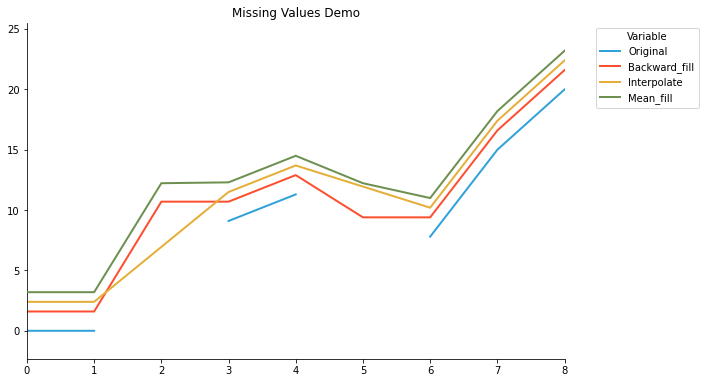

In [67]:
import hvplot 
hvplot.extension('matplotlib')

shift = .8
plot=(
    imp_pl
    .select(
        Original=pl.col('depth'),
        Backward_fill=pl.col('depth_bfill')+shift * 2,
        Interpolate=pl.col('depth_interp')+shift * 3,
        Mean_fill=pl.col('depth_mean')+shift * 4,
    )
    .hvplot(title='Missing Values Demo', width=800, height=500)
)

plot

---
# 5.13 Chapter Methods and Functions

[back to Top](#Top)

In [68]:
# For reference
autos.head(1)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""false""",5


## df.filter

* https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.filter.html
* Filter the rows in the DataFrame based on one or more predicate expressions.
* The original order of the remaining rows is preserved.
* Returns a new dataframe with only the rows that satisfy the condition.

In [69]:
(
    autos
    .filter((pl.col('year')==1985) & (pl.col('make')=='Alfa Romeo'))
)

dataframe filtered
dataframe filtered


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""false""",5
1985,"""Alfa Romeo""","""GT V6 2.5""",2.5,6,"""Manual 5-spd""","""Rear-Wheel Drive""","""Minicompact Cars""","""Regular""",15.658422,17,24,2013-01-01 00:00:00,"""false""",5


## df.describe()

* https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.describe.html#polars.DataFrame.describe
* Summary statistics for a DataFrame.


In [70]:
print(autos.describe())

shape: (9, 16)
+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+--------+
| sta | yea | mak | mod | dis | cyl | tra | dri | VCl | fue | bar | cit | hig | cre | is_ | num_ge |
| tis | r   | e   | el  | pl  | ind | ny  | ve  | ass | lTy | rel | y08 | hwa | ate | aut | ars    |
| tic | --- | --- | --- | --- | ers | --- | --- | --- | pe  | s08 | --- | y08 | dOn | oma | ---    |
| --- | f64 | str | str | f64 | --- | str | str | str | --- | --- | f64 | --- | --- | tic | f64    |
| str |     |     |     |     | f64 |     |     |     | str | f64 |     | f64 | str | --- |        |
|     |     |     |     |     |     |     |     |     |     |     |     |     |     | str |        |
+==================================================================================================+
| cou | 482 | 482 | 482 | 472 | 472 | 481 | 470 | 482 | 482 | 482 | 482 | 482 | 482 | 482 | 48202. |
| nt  | 02. | 02  | 02  | 39. | 37. | 91  | 16  | 02  | 02  | 02. | 02. | 02

## df.glimpse()

* Return a dense preview of the DataFrame.
* The formatting shows one line per column so that wide dataframes display cleanly.
* Each line shows the column name, the data type, and the first few values.
* GB: Akin to df.head()

In [71]:
autos.glimpse(max_items_per_column=3)

Rows: 48202
Columns: 15
$ year                  <i16> 1985, 1985, 1985
$ make                  <cat> Alfa Romeo, Ferrari, Dodge
$ model                 <cat> Spider Veloce 2000, Testarossa, Charger
$ displ                 <f32> 2.0, 4.900000095367432, 2.200000047683716
$ cylinders              <u8> 4, 12, 4
$ trany                 <str> 'Manual 5-spd', 'Manual 5-spd', 'Manual 5-spd'
$ drive                 <cat> Rear-Wheel Drive, Rear-Wheel Drive, Front-Wheel Drive
$ VClass                <cat> Two Seaters, Two Seaters, Subcompact Cars
$ fuelType              <cat> Regular, Regular, Regular
$ barrels08             <f32> 14.167142868041992, 27.046363830566406, 11.018888473510742
$ city08                 <u8> 19, 9, 23
$ highway08              <u8> 25, 14, 33
$ createdOn    <datetime[μs]> 2013-01-01 00:00:00, 2013-01-01 00:00:00, 2013-01-01 00:00:00
$ is_automatic          <str> 'false', 'false', 'false'
$ num_gears              <u8> 5, 5, 5



## df.drop_nulls()

* https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.drop_nulls.html#polars.DataFrame.drop_nulls
* Drop all rows that contain null values.
* The original order of the remaining rows is preserved.

In [72]:
(
    autos
    .drop_nulls().head()
)

dataframe filtered


year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
i16,cat,cat,f32,u8,str,cat,cat,cat,f32,u8,u8,datetime[μs],str,u8
1985,"""Alfa Romeo""","""Spider Veloce 2000""",2.0,4,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",14.167143,19,25,2013-01-01 00:00:00,"""false""",5
1985,"""Ferrari""","""Testarossa""",4.9,12,"""Manual 5-spd""","""Rear-Wheel Drive""","""Two Seaters""","""Regular""",27.046364,9,14,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""Charger""",2.2,4,"""Manual 5-spd""","""Front-Wheel Drive""","""Subcompact Cars""","""Regular""",11.018888,23,33,2013-01-01 00:00:00,"""false""",5
1985,"""Dodge""","""B150/B250 Wagon 2WD""",5.2,8,"""Automatic 3-spd""","""Rear-Wheel Drive""","""Vans""","""Regular""",27.046364,10,12,2013-01-01 00:00:00,"""true""",3
1993,"""Subaru""","""Legacy AWD Turbo""",2.2,4,"""Manual 5-spd""","""4-Wheel or All-Wheel Drive""","""Compact Cars""","""Premium""",15.658422,17,23,2013-01-01 00:00:00,"""false""",5


## col.is_between(lower_bound, upper_bound, closed='both')

* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.is_between.html#polars.Expr.is_between
* Check if this expression is between the given lower and upper bounds.
* Returns: Expression of data type Boolean.

In [73]:
(
    autos
    .with_columns(
        cylinders_1_2=pl.col('cylinders').is_between(1, 2)
    )
    .select(['year', 'make', 'cylinders_1_2'])
)

year,make,cylinders_1_2
i16,cat,bool
1985,"""Alfa Romeo""",false
1985,"""Ferrari""",false
1985,"""Dodge""",false
1985,"""Dodge""",false
1993,"""Subaru""",false
…,…,…
1993,"""Subaru""",false
1993,"""Subaru""",false
1993,"""Subaru""",false


In [74]:
# Variation using together with .filter(), .with_columns, custom name
(
    autos
    .with_columns(cylinders_1_2=pl.col('cylinders'))
    .filter(
        pl.col('cylinders_1_2').is_between(1, 2)
    )
    .select(['year', 'make', 'cylinders_1_2'])
)

dataframe filtered


year,make,cylinders_1_2
i16,cat,u8
1994,"""Mazda""",2
1994,"""Mazda""",2
1995,"""Mazda""",2
1995,"""Mazda""",2
1985,"""Mazda""",2
…,…,…
1991,"""Mazda""",2
1992,"""Mazda""",2
1992,"""Mazda""",2


## col.is_null(), polars.Expr.is_null()

* Returns a boolean Series indicating which values are null.


In [75]:
# df.with_columns(pl.all().is_null().name.suffix("_isnull"))  # nan != null

(
    autos
    .select(
        pl.col("*").is_null().any()
    )
)

year,make,model,displ,cylinders,trany,drive,VClass,fuelType,barrels08,city08,highway08,createdOn,is_automatic,num_gears
bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
false,false,false,true,true,true,true,false,false,false,false,false,false,false,false


In [76]:
test1 = (
    autos
    .with_columns(
        pl.col("year"),
        pl.col("make"),
        pl.col("displ").is_null().name.suffix("_isnull")
    )
    .select("year", "make", "displ", "displ_isnull")
)

print(test1.estimated_size())
test1

497490


year,make,displ,displ_isnull
i16,cat,f32,bool
1985,"""Alfa Romeo""",2.0,false
1985,"""Ferrari""",4.9,false
1985,"""Dodge""",2.2,false
1985,"""Dodge""",5.2,false
1993,"""Subaru""",2.2,false
…,…,…,…
1993,"""Subaru""",2.2,false
1993,"""Subaru""",2.2,false
1993,"""Subaru""",2.2,false


In [77]:
# Another variation: .with_columns(.is_null()) -> .filter -> .select
test2 = (
    autos
    .with_columns(
        pl.col("year"),
        pl.col("make"),
        pl.col("displ").is_null().name.suffix("_isnull")
    )
    .filter(pl.col("displ_isnull"))
    .select("year", "make", "displ", "displ_isnull")
)

print(test2.estimated_size())
test2

13292


dataframe filtered


year,make,displ,displ_isnull
i16,cat,f32,bool
2000,"""Nissan""",null,true
2000,"""Toyota""",null,true
2001,"""Toyota""",null,true
2001,"""Ford""",null,true
2001,"""Ford""",null,true
…,…,…,…
2024,"""Mercedes-Benz""",null,true
2024,"""Tesla""",null,true
2024,"""Tesla""",null,true


In [78]:
# Another variation: .select -> .with_columns(.is_null()) -> .filter
test3 = (
    autos
    .select("year", "make", "displ")
    .with_columns(
        pl.col("year"),
        pl.col("make"),
        pl.col("displ").is_null().name.suffix("_isnull")
    )
    .filter(pl.col("displ_isnull"))
)

print(test3.estimated_size())
test3

13292


dataframe filtered


year,make,displ,displ_isnull
i16,cat,f32,bool
2000,"""Nissan""",null,true
2000,"""Toyota""",null,true
2001,"""Toyota""",null,true
2001,"""Ford""",null,true
2001,"""Ford""",null,true
…,…,…,…
2024,"""Mercedes-Benz""",null,true
2024,"""Tesla""",null,true
2024,"""Tesla""",null,true


## col.null_count(), polars.Expr.null_count, 

* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.null_count.html#polars.Expr.null_count
* Count null values.

In [79]:
(
    autos
    .select(pl.col('displ').null_count())
)

displ
u32
963


## polars.DataFrame.null_count
* https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.DataFrame.null_count.html#polars.DataFrame.null_count
* Create a new DataFrame that shows the null counts per column.

In [80]:
# very easy to understand UX when used with .glimpse
(
    autos
    .null_count()
).glimpse()

Rows: 1
Columns: 15
$ year         <u32> 0
$ make         <u32> 0
$ model        <u32> 0
$ displ        <u32> 963
$ cylinders    <u32> 965
$ trany        <u32> 11
$ drive        <u32> 1186
$ VClass       <u32> 0
$ fuelType     <u32> 0
$ barrels08    <u32> 0
$ city08       <u32> 0
$ highway08    <u32> 0
$ createdOn    <u32> 0
$ is_automatic <u32> 0
$ num_gears    <u32> 0



In [81]:
# equivalent to this:
(
    autos
    .select(pl.all().null_count())
).glimpse()

Rows: 1
Columns: 15
$ year         <u32> 0
$ make         <u32> 0
$ model        <u32> 0
$ displ        <u32> 963
$ cylinders    <u32> 965
$ trany        <u32> 11
$ drive        <u32> 1186
$ VClass       <u32> 0
$ fuelType     <u32> 0
$ barrels08    <u32> 0
$ city08       <u32> 0
$ highway08    <u32> 0
$ createdOn    <u32> 0
$ is_automatic <u32> 0
$ num_gears    <u32> 0



## col.fill_null

* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.fill_null.html#polars.Expr.fill_null
* Fill null values using the specified value or strategy.
* strategy: {None, ‘forward’, ‘backward’, ‘min’, ‘max’, ‘mean’, ‘zero’, ‘one’}

In [82]:
(
    autos
    .with_columns(
        displ_filled=pl.col('displ').fill_null(0)
    )
    .filter(pl.col('displ').is_null())
    .select(['year', 'make', 'model', 'displ', 'displ_filled'])
)

dataframe filtered


year,make,model,displ,displ_filled
i16,cat,cat,f32,f32
2000,"""Nissan""","""Altra EV""",null,0.0
2000,"""Toyota""","""RAV4 EV""",null,0.0
2001,"""Toyota""","""RAV4 EV""",null,0.0
2001,"""Ford""","""Th!nk""",null,0.0
2001,"""Ford""","""Explorer USPS Electric""",null,0.0
…,…,…,…,…
2024,"""Mercedes-Benz""","""EQB 300 4matic""",null,0.0
2024,"""Tesla""","""Model 3 Long Range AWD-E""",null,0.0
2024,"""Tesla""","""Model Y Long Range AWD-I""",null,0.0


In [83]:
# equivalent to this:
(
    autos
    .select(pl.all().null_count())
).glimpse()

Rows: 1
Columns: 15
$ year         <u32> 0
$ make         <u32> 0
$ model        <u32> 0
$ displ        <u32> 963
$ cylinders    <u32> 965
$ trany        <u32> 11
$ drive        <u32> 1186
$ VClass       <u32> 0
$ fuelType     <u32> 0
$ barrels08    <u32> 0
$ city08       <u32> 0
$ highway08    <u32> 0
$ createdOn    <u32> 0
$ is_automatic <u32> 0
$ num_gears    <u32> 0



## col.fill_nan()

* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.fill_nan.html#polars.Expr.fill_nan
* Fill floating point NaN value with a fill value.
* Note that floating point NaNs (Not a Number) are not missing values. To replace missing values, use fill_null().

In [84]:
# Test for NaN; no built-in method for this in Polars
(
    autos
    .select(cs.numeric().is_nan().sum())
).glimpse()

Rows: 1
Columns: 7
$ year      <u32> 0
$ displ     <u32> 0
$ cylinders <u32> 0
$ barrels08 <u32> 0
$ city08    <u32> 0
$ highway08 <u32> 0
$ num_gears <u32> 0



In [85]:
# Problem is we can't tell if a column has been filled or not.
(
    autos
    .with_columns(
        pl.col('year').fill_nan(0).name.suffix("_filled_nan")
    )
    .select(['year', 'year_filled_nan'])
)

year,year_filled_nan
i16,i16
1985,1985
1985,1985
1985,1985
1985,1985
1993,1993
…,…
1993,1993
1993,1993
1993,1993


## col.interpolate()

* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.interpolate.html#polars.Expr.interpolate
* Fill null values using interpolation.

In [86]:
autos.null_count().glimpse()

Rows: 1
Columns: 15
$ year         <u32> 0
$ make         <u32> 0
$ model        <u32> 0
$ displ        <u32> 963
$ cylinders    <u32> 965
$ trany        <u32> 11
$ drive        <u32> 1186
$ VClass       <u32> 0
$ fuelType     <u32> 0
$ barrels08    <u32> 0
$ city08       <u32> 0
$ highway08    <u32> 0
$ createdOn    <u32> 0
$ is_automatic <u32> 0
$ num_gears    <u32> 0



In [87]:
# In order to interpolate to work, we need to have non-null values also in the column
(
    autos
    .select(['year', 'make', 'model', 'displ'])
    .with_columns(
        displ_filled = pl.col('displ').interpolate(method='nearest')
    )
    .filter(pl.col('displ').is_null())
)

dataframe filtered


year,make,model,displ,displ_filled
i16,cat,cat,f32,f32
2000,"""Nissan""","""Altra EV""",null,3.3
2000,"""Toyota""","""RAV4 EV""",null,3.0
2001,"""Toyota""","""RAV4 EV""",null,3.3
2001,"""Ford""","""Th!nk""",null,1.3
2001,"""Ford""","""Explorer USPS Electric""",null,1.3
…,…,…,…,…
2024,"""Mercedes-Benz""","""EQB 300 4matic""",null,2.2
2024,"""Tesla""","""Model 3 Long Range AWD-E""",null,6.2
2024,"""Tesla""","""Model Y Long Range AWD-I""",null,6.2


In [88]:
df = pl.DataFrame(
    {
        "a": [1, None, 3],
        "b": [1.0, float("nan"), 3.0],
    }
)
print(df)
df.select(pl.all().interpolate())

shape: (3, 2)
+------+-----+
| a    | b   |
| ---  | --- |
| i64  | f64 |
+============+
| 1    | 1.0 |
| null | NaN |
| 3    | 3.0 |
+------+-----+


a,b
f64,f64
1.0,1.0
2.0,NaN
3.0,3.0


## col.over()

* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.Expr.over.html#polars.Expr.over
* Compute expressions over the given groups.
* This expression is similar to performing a group by aggregation and joining the result back into the original DataFrame.
* The outcome is similar to how window functions work in PostgreSQL.

In [89]:
# Standard use, returns full dataframe in original order
(
    autos
    .select(
        pl.col(['make', 'model']),
        pl.col('city08').max().over(['make', 'model']).name.suffix('_max')
    )
)

make,model,city08_max
cat,cat,u8
"""Alfa Romeo""","""Spider Veloce 2000""",19
"""Ferrari""","""Testarossa""",10
"""Dodge""","""Charger""",26
"""Dodge""","""B150/B250 Wagon 2WD""",15
"""Subaru""","""Legacy AWD Turbo""",17
…,…,…
"""Subaru""","""Legacy""",21
"""Subaru""","""Legacy""",21
"""Subaru""","""Legacy AWD""",27


In [90]:
# Use group_by see the over-grouping of ['make','model'] easier.
(
    autos
    .with_columns(
        pl.col(['make', 'model']),
        pl.col('city08').max().over(['make', 'model']).name.suffix('_max')
    )
    .group_by(['make', 'model']).all()
    .sort(
        pl.col("city08_max").list.to_struct("max_width"), 
        descending=True, 
        nulls_last=True    
    )
    .select(['make', 'model', 'city08_max'])
)

keys/aggregates are not partitionable: running default HASH AGGREGATION


make,model,city08_max
cat,cat,list[u8]
"""Hyundai""","""Ioniq 6 Long range RWD (18 inc…","[153, 153]"
"""Hyundai""","""Ioniq 6 Standard Range RWD""","[151, 151]"
"""Hyundai""","""Ioniq 6 Standard Range""",[151]
"""Hyundai""","""Ioniq Electric""","[150, 150, … 150]"
"""Tesla""","""Model 3 Standard Range Plus RW…",[150]
…,…,…
"""Ferrari""","""Ferrari F50""",[7]
"""Ferrari""","""Enzo Ferrari""",[7]
"""Rolls-Royce""","""Corniche II/Continental""",[7]


## group_by.GroupBy.len()

* https://docs.pola.rs/py-polars/html/reference/dataframe/api/polars.dataframe.group_by.GroupBy.len.html#polars.dataframe.group_by.GroupBy.len
* Return the number of rows in each group.
* This replaces the deprecated `group_by.GroupBy.count`

In [91]:
# This is pretty useful!
(
    autos
    .group_by('make', 'model')
    .len()
    .sort(by='len', descending=True)
)

estimated unique values: 22060
estimated unique count: 22060 exceeded the boundary: 1000, running default HASH AGGREGATION


make,model,len
cat,cat,u32
"""Ford""","""F150 Pickup 2WD""",229
"""Chevrolet""","""Camaro""",220
"""Ford""","""Mustang""",215
"""Ford""","""F150 Pickup 4WD""",211
"""Volkswagen""","""Jetta""",203
…,…,…
"""Federal Coach""","""85J""",1
"""Daihatsu""","""Charade E""",1
"""Porsche""","""Panamera 4S e-Hybrid ST""",1


In [92]:
# Group by year for more granular detail
# Sort multiple columns: year-ascending, len-descending
(
    autos
    .group_by('year','make', 'model')
    .len()
    .sort(by=['year', 'len'], descending=[False, True])
)

keys/aggregates are not partitionable: running default HASH AGGREGATION


year,make,model,len
i16,cat,cat,u32
1984,"""Ford""","""F150 Pickup 2WD""",19
1984,"""GMC""","""C15 Pickup 2WD""",19
1984,"""Chevrolet""","""C10 Pickup 2WD""",19
1984,"""Chevrolet""","""S10 Pickup 2WD""",18
1984,"""GMC""","""S15 Pickup 2WD""",18
…,…,…,…
2025,"""BMW""","""X4 M Competition""",1
2025,"""Subaru""","""Forester Sport/Touring AWD""",1
2025,"""Hyundai""","""Tucson Hybrid Blue""",1


## pl.lit

* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.lit.html#polars.lit
* Return an expression representing a literal value.

In [93]:
import datetime

# Literal scalar values
print(pl.lit(1)) 
print(pl.lit(5.5)) 
print(pl.lit(None))
print(pl.lit("foo_bar")) 
print(pl.lit(datetime.date(2021, 1, 20))) 
print(pl.lit(datetime.datetime(2023, 3, 31, 10, 30, 45))) 

dyn int: 1
dyn float: 5.5
null
String(foo_bar)
2021-01-20
2023-03-31 10:30:45.strict_cast(Datetime(Microseconds, None))


In [94]:
# Literal list/Series data (1D)
print(pl.lit([1, 2, 3]))
print(pl.lit(pl.Series("x", [1, 2, 3])))

[1, 2, 3]
Series[x]


## pl.when()

* https://docs.pola.rs/py-polars/html/reference/expressions/api/polars.when.html
* Start a when-then-otherwise expression.

In [95]:
autos.select(pl.col('drive'))

drive
cat
"""Rear-Wheel Drive"""
"""Rear-Wheel Drive"""
"""Front-Wheel Drive"""
"""Rear-Wheel Drive"""
"""4-Wheel or All-Wheel Drive"""
…
"""Front-Wheel Drive"""
"""Front-Wheel Drive"""
"""4-Wheel or All-Wheel Drive"""


In [96]:
drive_str = pl.col('drive').cast(pl.String)

(
    autos
    .select(
        pl.col(['make', 'model', 'drive']),
        drive_check = pl
            .when(drive_str.str.contains('4-Wheel')).then(pl.lit("4-Wheeler"))
            .when(drive_str.str.contains('All-Wheel Drive')).then(pl.lit("4-Wheeler"))
            .otherwise(pl.lit("NON 4-WHEELER")),
    )
    .sort(by=['make','drive_check'])
)

make,model,drive,drive_check
cat,cat,cat,str
"""Eagle""","""Talon""","""4-Wheel or All-Wheel Drive""","""4-Wheeler"""
"""Eagle""","""Summit Wagon""","""4-Wheel or All-Wheel Drive""","""4-Wheeler"""
"""Eagle""","""Summit Wagon""","""4-Wheel or All-Wheel Drive""","""4-Wheeler"""
"""Eagle""","""Summit Wagon""","""4-Wheel or All-Wheel Drive""","""4-Wheeler"""
"""Eagle""","""Summit Wagon""","""4-Wheel or All-Wheel Drive""","""4-Wheeler"""
…,…,…,…
"""Consulier Industries Inc""","""Consulier GTP""","""Rear-Wheel Drive""","""NON 4-WHEELER"""
"""Goldacre""","""Goldacre Limited""","""Rear-Wheel Drive""","""NON 4-WHEELER"""
"""Isis Imports Ltd""","""Morgan Plus 8""","""Rear-Wheel Drive""","""NON 4-WHEELER"""
